# Analysing Dataset

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

This notebook is dedicated to datasets analysis. 

Here we will concentrate on connecting our datasets into one dataframe that will later be used to extract meaningful information that can help us answer our research questions. 

In addition, data cleaning is performed where necessary since we will not use all the data provided. The goal of this notebook is to make data as easy as possible to use for future plotting and data story writing.

So, let's dive into our data!

In [2]:
import os
import re
import json
import time
import datetime
from functools import reduce
from itertools import product

from json import load, JSONDecodeError
from functional import pseq, seq
import pandas as pd
import pandas_profiling
import requests
import pathlib

# necessary to load the utils, which are in src
import sys
sys.path.append('../src')

from utils import file, logging
from utils.statement_handling import extract_information, safe_json_read

from importlib import reload

import utils.statement_handling as SH
reload(SH)

<module 'utils.statement_handling' from '../src/utils/statement_handling.py'>

In [3]:
def group_and_count(df, groupby_column, with_pct=False, with_avg=False):
    result = df.groupby(groupby_column).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
    if with_pct:
        result['count_pct'] = result['count'] / result['count'].sum()
    if with_avg:
        result['count_avg'] = result['count'].mean()
    return result

In [4]:
directory_liar_dataset = "../data/liar_dataset"
directory_statements = f"{directory_liar_dataset}/statements"
directory_visualizations = "../docs/data_insight"
directory_election_results = "../data/election_results"
directory_county_data = "../data/county_data"

# LIAR Dataset

This is just the LIAR dataset:

In [5]:
statements = seq(pathlib.Path(directory_statements).iterdir()).map(safe_json_read)\
                               .filter(lambda x: len(x) > 0)\
                               .map(extract_information)\
                               .to_pandas()

statements['statement_date'] = pd.to_datetime(statements['statement_date'])
statements.sample(10)

ERROR:root:File ../data/liar_dataset/statements/5355.json is empty or something...
ERROR:root:File ../data/liar_dataset/statements/9.json is empty or something...


,author_name_slug,context,label,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement,statement_date,statement_id,statement_type,statement_type_description,subject
14782,tom-kertscher,a news release,true,2015-03-18T05:00:00,"State Senator, District 4",Lena,Wisconsin,Taylor,Polling shows that nearly 74 percent of Nation...,2015-03-12,10626,Claim,blog post,Civil Rights
12235,jon-greenberg,the first presidential debate,half-true,2012-10-04T00:15:24,President,Barack,Illinois,Obama,Says Mitt Romney&#39;s plan calls for a $5 tri...,2012-10-03,6833,Claim,blog post,Debates
4127,miriam-valverde,a blog post,pants-fire,2018-05-04T11:58:11,,,,Bloggers,Thousands killed as Israel Drops Tactical Nucl...,2018-04-30,15354,Claim,blog post,Fake news
7939,robert-farley,"Denver, Co.",false,2008-07-09T00:00:00,U.S. senator,John,Arizona,McCain,If you have an investment for your childs educ...,2008-07-07,561,Attack,<p>\r\n\tA criticism of a candidate.</p>\r\n,Taxes
14019,amy-sherman,an interview on MSNBC,mostly-true,2013-11-11T10:33:10,,Charlie,Florida,Crist,Says Rick Scott cut education by $1.3 billion ...,2013-11-05,8524,Claim,blog post,Education
9274,dave-umhoefer,a tweet,half-true,2013-01-20T09:00:00,Milwaukee County Executive,Scott,Wisconsin,Walker,"Thanks to Washington, nearly everyone will pay...",2013-01-04,7265,Attack,<p>\r\n\tA criticism of a candidate.</p>\r\n,Economy
12347,adriel-bettelheim,a speech to the Americans for Prosperity Michi...,half-true,2008-01-16T00:00:00,U.S. senator,John,Arizona,McCain,"Congress just passed another huge, pork-filled...",2008-01-12,286,Claim,blog post,Federal Budget
14590,robert-farley,in a press release,false,2008-03-14T00:00:00,,,Tennessee,Tennessee Republican Party,You dont even have to go outside Obamas campai...,2008-02-25,395,Attack,<p>\r\n\tA criticism of a candidate.</p>\r\n,Israel
2153,c-eugene-emery,a posting on his website,false,2010-06-27T00:01:00,,Mark S.,Rhode Island,Zaccaria,<span id=internal-source-marker_0.395255026839...,2010-06-02,1947,Claim,blog post,Bipartisanship
10059,nancy-badertscher,press release,half-true,2015-11-13T00:00:00,website,,Georgia,Kiplinger.com,Georgia is one of the 10 most tax-friendly sta...,2015-10-26,11565,Claim,blog post,Income


In [6]:
statements['speaker_last_name'].eq('Trump').sum()

646

In [7]:
print('The number of different context names is: {}.\
 That is much too many different contexts and lots of them appear only a few times.\
 We thus need to regroup/reduce the number of contexts.'.format(group_and_count(statements, 'context').shape[0]))

The number of different context names is: 5828. That is much too many different contexts and lots of them appear only a few times. We thus need to regroup/reduce the number of contexts.


In [8]:
group_and_count(statements, 'context').head(100)

,context,count
0,a tweet,471
1,an interview,380
2,a news release,329
3,a press release,325
4,a speech,319
5,a TV ad,275
6,a campaign ad,221
7,a headline,175
8,a television ad,168
9,,166


So how to regroup all these or part of these?
We can use the mean of communication for example:
radio/tv/facebook/twitter/internet
and these classes can have overlap...

In [9]:
statements['clean_context'] = statements['context'].apply(SH.clean_up_context)

In [10]:
# no longer necessary
if false:
    df['label_as_nb'] = df['label'].apply(label_to_nb) * 2 
    df['statement_id'] = pd.to_numeric(df['statement_id'])
    lies = df.merge(additional_information, on='statement_id', how='left')

NameError: name 'false' is not defined

Let's just see what we have here:

In [11]:
# TODO rene add new values, see trello board
lies['label_to_nb'] = lies['label'].apply(label_to_nb) * 2

NameError: name 'lies' is not defined

In [12]:
lies['label'].value_counts()

NameError: name 'lies' is not defined

In [13]:
def _count_for_last_name_(df, last_name):
    return group_and_count(lies.loc[lies['speaker_last_name'].str.contains(last_name, flags=re.IGNORECASE), :], 'label', with_pct=True)\
            .rename(columns={'count': f'count_{last_name}', 'count_pct': f'count_pct{last_name}'})

In [14]:
pd.merge(_count_for_last_name_(lies, 'obama'), _count_for_last_name_(lies, 'trump'), on='label')

NameError: name 'lies' is not defined

Here we can see that Barack Obama had 549 statements labeled with _pants on fire_.

In [15]:
lies[lies['speakers_job_title'].str.contains('County') == True].shape

NameError: name 'lies' is not defined

In [16]:
lies['statement_date'].describe()

NameError: name 'lies' is not defined

Above, we can see that statements range from 1995 to 2016.

Now, let's do some profiling to get some more insights:

In [17]:
pandas_profiling.ProfileReport(lies)

NameError: name 'lies' is not defined

# Federal Election Results

We have another dataset that we will explore and merge to our LIAR dataset in order to get some more insight into data. This one is regarding election results.

In [18]:
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 300

In [19]:
from itertools import product
from functools import reduce

In [20]:
def add_ending(f):
    """ File ending depending on a year
    
    Parameters
    ----------
    f: str
        Name of the file
    
    ToDos:
    - do 2012 it's a special snowflake
    """
    if '2016' in f:
        return f"{f}x"
    else:
        return f


election_files = [(add_ending(f'{directory_election_results}/federalelections{year}.xls'), year) for year in [2014, 2016]]

Now, let's prepare some data for viewing:

In [21]:
election_results_cols_of_interest = ['CANDIDATE NAME', 'PRIMARY VOTES', 'PRIMARY %']

def fix_columns_election_results(df, year, type_):
    """we are only interested in the primary votes, since these reflect the opinion the most"""
    df = df.loc[:, election_results_cols_of_interest]
    df[f'primary_votes_{type_.lower()}_{year}'] = df['PRIMARY VOTES']
    df[f'primary_votes_{type_.lower()}_{year}_pct'] = df['PRIMARY %']
    return df.drop(columns=['PRIMARY VOTES', 'PRIMARY %'])


def get_only_voting_results(df):
    return df.loc[df['CANDIDATE NAME'].notna() & df['PRIMARY VOTES'].notna() & df['CANDIDATE NAME'].ne('Scattered') & df['CANDIDATE NAME'].ne('All Others'), :]


def prep_election_results(df, year, type_):
    return fix_columns_election_results(get_only_voting_results(df), year, type_)

In [22]:
election_results = [prep_election_results(pd.read_excel(f, sheet_name=f'{year} US {type_} Results by State'), year, type_) for (f, year), type_ in product(election_files, ['Senate', 'House'])]

# we let the results as they are, merge, and then check if the person is a senator or a member of the house based on the other results
# yes they did a spelling mistake
election_results += [prep_election_results(pd.read_excel(f'{directory_election_results}/federalelections2012.xls', sheet_name=f'2012 US House & Senate Resuts'), 2012, 'all')]
election_results = reduce(lambda acc, el: pd.merge(acc, el, on='CANDIDATE NAME', how='outer'), election_results)

In [23]:
election_results.head()

,CANDIDATE NAME,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct,primary_votes_all_2012,primary_votes_all_2012_pct
0,"Sessions, Jeff",Unopposed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Sullivan, Dan",44740,0.400548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Miller, Joe",35904,0.321441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Treadwell, Mead",27807,0.248950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Jaramillo, John M.",3246,0.029061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
idx_multiple_election_results = election_results.loc[:, [c for c in election_results.columns if any((c.endswith(str(y)) for y in [2012, 2014, 2016]))]].notna().sum(axis=1) > 1

print(f"we have multple election results for {idx_multiple_election_results.sum()} politicians ({idx_multiple_election_results.mean()}%)")

we have multple election results for 1110 politicians (0.19618239660657477%)


In [25]:
election_results[idx_multiple_election_results].head()

,CANDIDATE NAME,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct,primary_votes_all_2012,primary_votes_all_2012_pct
16,"Gardner, Cory",338324,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,49340,1
19,"Wade, Kevin",18181,0.756627,NaN,NaN,NaN,NaN,NaN,NaN,Unopposed,NaN
32,"Schatz, Brian",115445,0.493460,NaN,NaN,162905,0.861662,NaN,NaN,NaN,NaN
33,"Hanabusa, Colleen Wakako",113663,0.485843,NaN,NaN,NaN,NaN,74022,0.803757,NaN,NaN
36,"Roco, John P.",4425,0.123572,NaN,NaN,3956,0.110303,NaN,NaN,545,0.0112848


In [26]:
# yeah ... let's see how many we can join. the one letter endings might be a problem
election_results['CANDIDATE NAME'].value_counts()

Tonko, Paul D.               36
Reed, Thomas W., II          36
Collins, Chris               24
Lowey, Nita M.               12
Maloney, Sean Patrick        12
Engel, Eliot L.              12
Katko, John M.               12
Nadler, Jerrold L.           12
Slaughter, Louise M.         12
Higgins, Brian               12
Crowley, Joseph              12
King, Peter T.                9
Israel, Steve J.              9
Gibson, Christopher P.        9
Assini, Mark W.               8
Maloney, Carolyn B.           8
Stefanik, Elise M.            8
Kuster, Ann McLane            8
Clarke, Yvette D.             8
Jeffries, Hakeem S.           8
Zeldin, Lee M.                6
Grimm, Michael G.             6
Long, Wendy                   6
Hayworth, Nan                 6
Bishop, Timothy H.            6
Hanna, Richard L.             4
Rice, Kathleen M.             4
Fortenberry, Jeff             4
Scattered                     4
Shea-Porter, Carol            4
                             ..
Brady, K

In [27]:
# we are only interest in people and they have a first name
lies = lies.loc[lies['speaker_first_name'].notnull(), :]

NameError: name 'lies' is not defined

In [28]:
# to aggregate the statements
lies['statement_year'] = lies['statement_date'].dt.year

# for the merging
lies['speaker_full_name'] = lies['speaker_last_name'] + ', ' + lies['speaker_first_name']

NameError: name 'lies' is not defined

### Cleaning job titles

In [ ]:
# todo expand this and check this! this is just a quick and dirty fix
# is it really houseman? probably not...
_job_titles_of_interest = [('senat', 'senator'), ('governor', None), ('congress', 'congressman'), ('mayor', None), ('president', None), ('house', 'houseman'), ('rep', 'houseman')]
job_titles_of_interest = [out if out is not None else j for j, out in _job_titles_of_interest]

def cleaned_job_title(jt):
    jt = str(jt).lower()
    
    for j, out in _job_titles_of_interest:
        if j in jt:
            return out if out is not None else j
    else:
        return jt

lies['speakers_job_title_cleaned'] = lies['speakers_job_title'].apply(cleaned_job_title)

In [ ]:
_t = lies.merge(election_results, left_on='speaker_full_name', right_on='CANDIDATE NAME', how='outer')

In [ ]:
print(f"found election results for {_t['CANDIDATE NAME'].notnull().sum()} ({_t['CANDIDATE NAME'].notnull().mean()}%) people")

In [ ]:
votes_cols = [c for c in _t.columns if 'votes' in c]
useful_idx = reduce(lambda acc, el: acc | el, [_t[c].notnull() for c in votes_cols]) & _t['speaker'].notnull() 

print(f"found useful results for {useful_idx.sum()} people")

columns_of_interest = ['label', 'label_as_nb', 'subject', 'speaker', 'speakers_job_title_cleaned', 'state_info', 'party_affiliation', 'context', 'statement_date'] + votes_cols
_t.loc[useful_idx, columns_of_interest]

In [ ]:
_t.loc[useful_idx, 'speakers_job_title_cleaned'].value_counts()

In [ ]:
_t.loc[_t['speakers_job_title_cleaned'].isin(job_titles_of_interest) & useful_idx, columns_of_interest]

Now, our dataframe looks like this:

In [ ]:
_t.head(1)

# County Data

In [ ]:
# load data file
county_raw = pd.read_csv(f"{directory_county_data}/acs2015_county_data.csv")
US_states = county_raw['State'].unique()
county_raw.head()

# DATA SET COMPLETE

At this point, we collected all the columns we need. Let's see how we can clean them:

In [29]:
median_speaker_value = _t.groupby(['statement_year', 'speaker'])['label_as_nb'].median().reset_index()

NameError: name '_t' is not defined

In [30]:
median_speaker_value[median_speaker_value['statement_year'] == 2016]

NameError: name 'median_speaker_value' is not defined

### Non-People Speakers Handling

Removing non-people (_tweets, facebook posts, etc._) from the dataset:

In [ ]:
from nltk import download
download('punkt')
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from collections import Counter

model = 'nlp/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = 'nlp/stanford-ner-2018-10-16/stanford-ner-3.9.2.jar'
st = StanfordNERTagger(model, jar, encoding='utf-8')

def get_tag(speaker):
    ner_tag = 0
    if type(speaker) == str:
        full_speaker_name = speaker.replace("-", " ").title()

        for sent in sent_tokenize(full_speaker_name):
            tokens = word_tokenize(sent)
            tags = st.tag(tokens)
            
        ner_tag= Counter(dict(tags).values()).most_common(1)[0][0]
        print(tags, " --> ", ner_tag)
    return ner_tag
    

# just to see if/how it works
word = "Twitter-Post-Anna"
get_ner_tag(word)

full_speaker_name = "Barack-Obama"
get_ner_tag(full_speaker_name)

full_speaker_name = 0
get_ner_tag(full_speaker_name)


In [ ]:
import os.path

file_path = 'nlp/speaker_tags.json'

if not os.path.exists(file_path):
    print(f"Total number of values to classify: {len(_t['speaker'].value_counts().index)}")

    words_with_tags = {}
    for word in _t['speaker'].value_counts().index:
        words_with_tags[word] = get_tag(word)
    
    # save tags, since it took ~3h to tag all 3214 unique speakers
    with open(file_path, 'w') as fp:
        json.dump(words_with_tags, fp, indent=4)
else:
    with open(file_path, 'r') as f:
        words_with_tags = json.load(f)
    print(f"Total number of classified values (from file): {len(words_with_tags)}")

In [ ]:
_t["speaker_tag"] = _t.apply(lambda row: words_with_tags[row['speaker']] if not pd.isnull(row['speaker']) else row['speaker'], axis=1)
_t[['speaker','speaker_tag']].drop_duplicates()

Seems good, so now let's remove non-people from the dataset:

In [ ]:
_t.shape

In [ ]:
_t[_t['speaker_tag'] == "PERSON"].shape

We see that we will remove ~5000 statements which are made by (speaker) _Twitter, Facebook, Blog post, Republican Party Texas, etc._

In [ ]:
# removing non-people statements
_t = _t[_t['speaker_tag'] == "PERSON"]

### Clean-up Context

In [ ]:
_t["context"].value_counts().index.values

It would be good to try using the tool that would extract keywords from these phases. Let's use NLTK Rake:

In [ ]:
from rake_nltk import Rake, Metric
from collections import Counter

debug = False

def do_keyword_extraction(words):
    if debug: print("---\n", words)
        
    rake_all = Rake()
    rake_all.extract_keywords_from_sentences(_t["context"].value_counts().index.values)

    word_degrees = dict(rake_all.get_word_degrees())
    
    r = Rake()
    r.extract_keywords_from_text(words)

    keywords = dict(r.get_word_degrees())
    
    if debug: print(keywords)
        
    for k, v in keywords.items():
        keywords[k] = word_degrees[k]
    
    if debug: print(keywords)

    return Counter(keywords).most_common(1)[0]

In [ ]:
# try to see how it works
text_to_process = "a television interview"
do_keyword_extraction("an interview")
do_keyword_extraction("a television interview")
do_keyword_extraction("a TV interview")

In [ ]:
_t["context_tag"] = _t.apply(lambda row: do_keyword_extraction(row['context']) if not pd.isnull(row['context']) else row['context'], axis=1)

In [ ]:
context_tags = _t[['context','context_tag']]['context_tag'].value_counts()
print(f"Number of different context tags is {len(context_tags)}")
context_tags

We see that the number of context tags is 271, which is a preatty big number. Let's consider decreasing this number and make smaller groups.

In [ ]:
# TODO: make smaller context groups, ideally around 10

In [ ]:
# TODO: implement tagging on the cleaned jobs as well

In [ ]:
# TODO: plot the answers from research questions we have

## Some initial insights

In [ ]:
_t['sum_not_so_true'] = _t['pants_on_fire_counts']/(_t['barely_true_counts'] + _t['false_counts'] + _t['half_true_counts'] + _t['mostly_true_counts'] + _t['pants_on_fire_counts'])
number_of_party_affiliation = _t.groupby('party_affiliation')['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation

Here are the `party_affiliations` who most lie ordered by their proportion of lies. But we already know that the 2 dominant parties in USA are republican and democrat. We see that there are lots of unknown party affiliations from which we can make identify 2 possibilities

In [ ]:
number_of_party_affiliation = _t.groupby(['speaker'])['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation.head(10)

Looking at the dataset content, people above are sorted quantity of lies.

In [ ]:
all_contexts = _t['context_tag'].unique()
nb_elements_context = _t.groupby(['context_tag'])['context_tag'].count().sort_values(ascending=False)
nb_elements_context.head(50)

Looking at the context, it seems that people lie the most during the interviews, then speech, after debates, and so on...

## [misc] One statement content visualization

Let's analyse first row, statement with id `1`. What is the information we get there?

In [ ]:
sid = 1.0

In [ ]:
_t[_t.statement_id == sid]

In [ ]:
with open(f"{directory_statements}/{int(sid)}.json", "r") as f:
    data = json.load(f)

Just to visualize JSON hierarchy, run the following cell:

In [ ]:
def go_further(dic, name):
    dict_vis = {"name": name, "children": []}
    for k, v in dic.items():
        if type(v) == str:
            new_el = {"name": k}
        elif type(v) == list:
            if len(v) > 0:
                new_el = go_further(v[0], k)
        elif type(v) == dict:
            new_el = go_further(v, k)
        else:
            new_el = {"name": k}
        dict_vis["children"].append(new_el)
        
    return dict_vis

my_dict = go_further(data, name="statement_info")

with open(f"{directory_visualizations}/data.json", "w") as f:
    json.dump(my_dict, f)

print(f"Checkout visualization by: \n1) cd ../visualizations \n2) python -m http.server \n3) in browser, open: http://localhost:8000/")

## Biggest liars pants on fire

Here are the people who most lie ordered by their proportion of pants on fire.

In [ ]:
people_pants_classification = statements[['speaker_first_name', 'speaker_last_name', 'label', 'speaker_home_state']]
#people_pants_classification[(people_pants_classification['speaker_first_name'].isnull() | people_pants_classification['speaker_first_name'].str.strip().eq('')) == False][:1].values

# We want to keep only people which have both a first-name and a last-name (not totaly perfect)
people_pants_classification = people_pants_classification[((people_pants_classification['speaker_first_name'].isnull() |
                                                           people_pants_classification['speaker_first_name'].str.strip().eq('')) == False)]
people_pants_classification = people_pants_classification[((people_pants_classification['speaker_last_name'].isnull() |
                                                           people_pants_classification['speaker_last_name'].str.strip().eq('')) == False)]
people_pants_classification = people_pants_classification[((people_pants_classification['label'].isnull() |
                                                           people_pants_classification['label'].str.strip().eq('')) == False)]

_blop = people_pants_classification[['speaker_first_name', 'speaker_last_name']].groupby(['speaker_first_name', 'speaker_last_name']).size().reset_index()
_blopblop = people_pants_classification.groupby(['speaker_first_name', 'speaker_last_name', 'label']).size().reset_index().rename(columns={'0':'nb_labeled_statements'})

statement_percentage = pd.merge(_blopblop,_blop,on=['speaker_first_name', 'speaker_last_name'])

statement_percentage['statements_perc'] = statement_percentage['0_x']/statement_percentage['0_y']
#statement_percentage.sample(5)

#### Pants on fire analysis

In [ ]:
statement_percentage_cleaned = statement_percentage.loc[statement_percentage['label']=='pants-fire'].sort_values(by='statements_perc', ascending=False)

#### We need people who have at least a certain number of statements to limit bias

In [ ]:
statement_percentage_cleaned_numerous = statement_percentage_cleaned.loc[statement_percentage_cleaned['0_y']>20]
print('The 10 badest guys with the highest percentage of pants on fire are:')
statement_percentage_cleaned_numerous.head(10)

In [ ]:
statement_percentage_cleaned = statement_percentage_cleaned.loc[statement_percentage_cleaned['0_y']>1]
statement_percentage_cleaned.head(10)

In [99]:
%matplotlib inline
#statement_percentage_cleaned.plot(kind='scatter' y='statements_perc')
import seaborn as sns

In [ ]:
sns.distplot(statement_percentage_cleaned['0_y'], bins=50, kde=False, axlabel='number of statements for each person')

In [ ]:
sns.distplot(statement_percentage_cleaned.statements_perc, bins=50, kde=False, axlabel='percentage of "pants on fire" for each person')

In [ ]:
statement_percentage_cleaned_top10 = statement_percentage_cleaned.sort_values(['0_y'], ascending=[False]).head(10).sort_values(['statements_perc'], ascending=[False])
statement_percentage_cleaned_top10

In [ ]:
# Column renaming does not work
#.rename(columns={'0':'nb_statements'})
# to rename the column of counts df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
# _blop.rename(columns='0':'nb_statements')

In [ ]:
# Verification, not needed
_blop[_blop['speaker_last_name'].eq('Trump')]

## Blopy objects

In [31]:
safe_json_read(list(pathlib.Path(directory_statements).iterdir())[0])

{'art': [{'brightcove': '',
   'caption': 'Texas Sen. Steve Ogden, R-Bryan, and Republican Lt. Gov. David Dewhurst spoke to reporters April 5 about the state budget and the tax system.',
   'id': 1257,
   'infogram': '',
   'ndn': '',
   'ndnid': '',
   'other': '',
   'photo': None,
   'resource_type': {'id': 2,
    'name': 'YouTube',
    'resource_uri': '/api/v/2/mediatype/2/'},
   'resource_uri': '/api/v/2/media/1257/',
   'title': 'Steve Ogden, business tax',
   'wibbitz': '',
   'youtube': '<iframe src="//www.youtube.com/embed/EaRdqdEUrZQ?rel=0&wmode=opaque" frameborder="0" allowfullscreen></iframe>',
   'youtubeID': 'EaRdqdEUrZQ'}],
 'author': [{'email_address': 'mashford-grooms@statesman.com',
   'first_name': 'Meghan',
   'id': 118,
   'last_name': 'Ashford-Grooms',
   'name_slug': 'meghan-ashford-grooms',
   'on_staff_page': None,
   'phone': None,
   'photo': None,
   'publication': {'id': 3,
    'publication_name': 'Austin American-Statesman',
    'resource_uri': '/api/v/2/p

In [32]:
res.get('subject', {'description':''}).get('description','')

NameError: name 'res' is not defined

In [33]:
subject_toward_simplification = group_and_count(statements, 'subject', with_pct=True)
subject_toward_simplification.head(140)

,subject,count,count_pct
0,Economy,1244,0.080409
1,Health Care,1114,0.072006
2,Candidate Biography,819,0.052938
3,Education,813,0.052550
4,Elections,660,0.042660
5,Crime,570,0.036843
6,Federal Budget,529,0.034193
7,Immigration,477,0.030832
8,Taxes,473,0.030573
9,Foreign Policy,446,0.028828


In [71]:
statements['clean_subject'] = statements['subject'].apply(SH.clean_up_subject)

In [36]:
group_and_count(statements,'clean_subject').head(100)


,clean_subject,count
0,economy,3474
1,politics,2366
2,security,1632
3,family,1527
4,other_subject,1493
5,health,1318
6,fake,1019
7,immigration,923
8,environment,916
9,rights,803


#### Plot ratio over the years

In [119]:
objects_along_time = statements[['statement_date', 'clean_subject']]
objects_along_time['dates_for_plot'] = statements.statement_date.dt.year*100+statements.statement_date.dt.month
#objects_along_time['dates_for_plot'] = statements[['statement_date', 'clean_subject']]#.statement_date.dt.year*100+statements.statement_date.dt.month
objects_along_time.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,statement_date,clean_subject,dates_for_plot
0,2011-04-05,economy,201104
1,2010-11-04,economy,201011
2,2016-10-09,politics,201610
3,2008-09-17,rights,200809
4,2018-10-12,health,201810


In [120]:
objects_along_time.groupby(['dates_for_plot', 'clean_subject']).head(5)


,statement_date,clean_subject,dates_for_plot
0,2011-04-05,economy,201104
1,2010-11-04,economy,201011
2,2016-10-09,politics,201610
3,2008-09-17,rights,200809
4,2018-10-12,health,201810
5,2012-08-10,other_subject,201208
6,2012-08-01,economy,201208
7,2011-02-22,family,201102
8,2008-08-31,politics,200808
9,2017-01-12,environment,201701


In [121]:
objects_along_time = group_and_count(objects_along_time, ['dates_for_plot', 'clean_subject'])

In [65]:
list(objects_along_time)

['dates_for_plot', 'clean_subject', 'count']

In [89]:
objects_along_time.plot.scatter('dates_for_plot', 'count')

In [92]:
plt.scatter(objects_along_time['dates_for_plot'], objects_along_time['count'], c="g", alpha=0.5, marker=r'$\clubsuit$', label="Luck")

NameError: name 'plt' is not defined

In [94]:
subjects = objects_along_time.clean_subject.unique()
subjects


array(['security', 'immigration', 'politics', 'rights', 'economy',
       'environment', 'fake', 'family', 'health', 'other_subject'],
      dtype=object)

ValueError: color kwarg must have one color per dataset

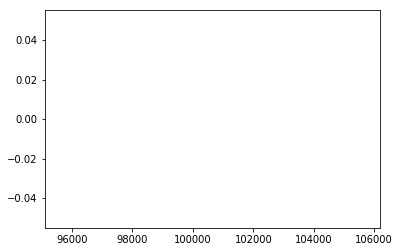

In [101]:
for type in objects_along_time['clean_subject'].unique():
    sns.distplot(objects_along_time[['dates_for_plot', 'count']].loc[objects_along_time['clean_subject'] == type, :])
    
# plt.savefig('../docs/images/sample_fig.png')

In [128]:
#caca = objects_along_time.loc[objects_along_time['clean_subject'] == 'environment']
#caca.head(5)
#list(caca)

['dates_for_plot', 'clean_subject', 'count']

TypeError: float() argument must be a string or a number, not 'method'

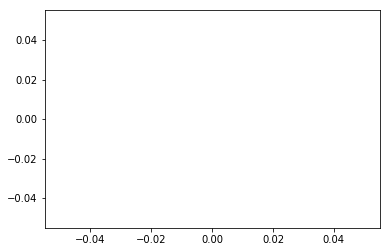

In [129]:
#sns.scatterplot(x=caca.dates_for_plot, y=caca.count)

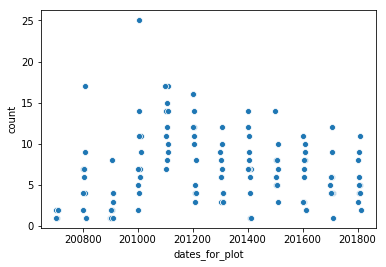

In [126]:

sns.scatterplot(x=objects_along_time['dates_for_plot'].loc[objects_along_time['clean_subject'] == 'environment'], y=objects_along_time['count'].loc[objects_along_time['clean_subject'] == 'environment'])

## Plot on which weekday people lie

In [42]:
list(statements)

['author_name_slug',
 'context',
 'label',
 'ruling_date',
 'speaker_current_job',
 'speaker_first_name',
 'speaker_home_state',
 'speaker_last_name',
 'statement',
 'statement_date',
 'statement_id',
 'statement_type',
 'statement_type_description',
 'subject',
 'clean_context',
 'clean_subject']

In [ ]:
statements['ruling_date'].dtypes

It is an object, Ok, so where are the days of the week in there????

In [ ]:
statements.ruling_date

In [ ]:
import calendar

c = calendar.HTMLCalendar(calendar.SUNDAY)
print c.formatmonth(2007, 7)

In [ ]:
import calendar

c = calendar.TextCalendar(calendar.SUNDAY)
for i in (1, 2, 3):
    c.prmonth(2007, i)

## Source of dataset

[politifact](https://www.politifact.com)

In [73]:
list(statements)

['author_name_slug',
 'context',
 'label',
 'ruling_date',
 'speaker_current_job',
 'speaker_first_name',
 'speaker_home_state',
 'speaker_last_name',
 'statement',
 'statement_date',
 'statement_id',
 'statement_type',
 'statement_type_description',
 'subject',
 'clean_context',
 'clean_subject']

## Author bias

In [77]:
cacablop = group_and_count(statements, 'author_name_slug')

In [79]:
cacablop.head(10)

,author_name_slug,count
0,louis-jacobson,1587
1,w-gardner-selby,899
2,jon-greenberg,719
3,amy-sherman,719
4,tom-kertscher,709
5,angie-drobnic-holan,603
6,robert-farley,446
7,c-eugene-emery,399
8,joshua-gillin,396
9,dave-umhoefer,358


In [85]:
cacablop.plot.scatter()